In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer
from tensorflow.keras.models import Sequential
import pandas as pd

In [3]:
f = pd.read_hdf("../events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")


In [4]:
G = (f[['pxj1','pxj2', 'pyj1', 'pyj2']]).to_numpy()
px1 = G[:, 0]
py1 = G[:, 2]
px2 = G[:, 1]
py2 = G[:, 3]

In [4]:
class MyLayer(Layer):

    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._t1 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval= 0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t2 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t3 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t4 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t5 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t6 = self.add_weight(name='x', 
                                    #shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, X):
        s1 = tf.math.sin(self._t1)
        c1 = tf.math.cos(self._t1)
        s2 = tf.math.sin(self._t2)
        c2 = tf.math.cos(self._t2)
        s3 = tf.math.sin(self._t3)
        c3 = tf.math.cos(self._t3)
        s4 = tf.math.sin(self._t4)
        c4 = tf.math.cos(self._t4)
        s5 = tf.math.sin(self._t5)
        c5 = tf.math.cos(self._t5)
        s6 = tf.math.sin(self._t6)
        c6 = tf.math.cos(self._t6)
        R1 = [[c1, s1, 0.0, 0.0], [-1.0*s1, c1, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]] #px1 -> py1     
        R2 = [[c2, 0.0, s2, 0.0], [0.0, 1.0, 0.0, 0.0], [-1.0*s2, 0.0, c2, 0.0], [0.0, 0.0, 0.0, 1.0]] #px1 -> px2
        R3 = [[c3, 0.0, 0.0, s3], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [-1.0*s3, 0.0, 0.0, c3]] #px1 -> py2
        R4 = [[1.0, 0.0, 0.0, 0.0], [0.0, c4, s4, 0.0], [0.0, -1.0*s4, c4, 0.0], [0.0, 0.0, 0.0, 1.0]] #px2 -> py1
        R5 = [[1.0, 0.0, 0.0, 0.0], [0.0, c5, 0.0, s5], [0.0, 0.0, 1.0, 0.0], [0.0, -1.0*s5, 0.0, c5]] #px2 -> py1
        R6 = [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, c6, s6], [0.0, 0.0, -1.0*s6, c6]] #py1 -> py2
        S = tf.linalg.matmul(R1, tf.linalg.matmul(R2, (tf.linalg.matmul(R3, tf.linalg.matmul(R4, tf.linalg.matmul(R5, R6))))))
        #S = R1 @ R2 @ R3 @ R4 @ R5 @ R6
        M = tf.convert_to_tensor(S)
        M = tf.reshape(M, [4, 4])
        return tf.linalg.matmul(X, M)

In [6]:
def define_discriminator(n_inputs=4):
	model = Sequential()
	model.add(Dense(25, activation='relu', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(n_outputs=1):
	#model = Sequential()
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))    
	#model.add(Dense(n_outputs, activation='linear'))

	mymodel_inputtest = Input(shape=(4,))
	mymodel_test = MyLayer()(mymodel_inputtest)
	model = Model(mymodel_inputtest, mymodel_test)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	randomlySelectedY = np.argsort(np.random.random(len(px1)))[:n]
	X = tf.convert_to_tensor([px1[randomlySelectedY], py1[randomlySelectedY], px2[randomlySelectedY], py2[randomlySelectedY]])
	y = np.ones((n, 1))
	return np.transpose(X), y
 
# generate points in latent space as input for the generator
def generate_latent_points(n):
	# generate points in the latent space
	x_input = generate_real_samples(n)
	return x_input[0]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y

def generate_fake_samples_with_input(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y, x_input

k = 600
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, n_epochs=5*k, n_batch=128, n_eval=k):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		if (i+1) % n_eval == 0:
			print("epoch = ", i)

In [8]:
N = 5
t1i = []
t1f = []
t2i = []
t2f = []
t3i = []
t3f = []
t4i = []
t4f = []
t5i = []
t5f = []
t6i = []
t6f = []
for j in range(N):
    print("j = ", j)
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator()
    # create the gan
    gan_model = define_gan(generator, discriminator)
    t1i.append(generator.layers[-1].get_weights()[0])
    t2i.append(generator.layers[-1].get_weights()[1])
    t3i.append(generator.layers[-1].get_weights()[2])
    t4i.append(generator.layers[-1].get_weights()[3])
    t5i.append(generator.layers[-1].get_weights()[4])
    t6i.append(generator.layers[-1].get_weights()[5])

    # train model
    train(generator, discriminator, gan_model)
    t1f.append(generator.layers[-1].get_weights()[0])
    t2f.append(generator.layers[-1].get_weights()[1])
    t3f.append(generator.layers[-1].get_weights()[2])
    t4f.append(generator.layers[-1].get_weights()[3])
    t5f.append(generator.layers[-1].get_weights()[4])
    t6f.append(generator.layers[-1].get_weights()[5])
    print("t1i = ", t1i)
    print("t2i = ", t2i)
    print("t3i = ", t3i)
    print("t4i = ", t4i)
    print("t5i = ", t5i)
    print("t6i = ", t6i)
    print()
    print("t1f = ", t1f)
    print("t2f = ", t2f)
    print("t3f = ", t3f)
    print("t4f = ", t4f)
    print("t5f = ", t5f)
    print("t6f = ", t6f)


j =  0
epoch =  599
epoch =  1199
epoch =  1799
epoch =  2399
epoch =  2999
t1i =  [6.056876]
t2i =  [3.6927586]
t3i =  [5.651276]
t4i =  [4.795601]
t5i =  [5.677244]
t6i =  [1.2972939]

t1f =  [5.5788875]
t2f =  [3.836613]
t3f =  [6.7977567]
t4f =  [5.769172]
t5f =  [6.9649653]
t6f =  [0.9678819]
j =  1
epoch =  599
epoch =  1199
epoch =  1799
epoch =  2399
epoch =  2999
t1i =  [6.056876, 0.32362726]
t2i =  [3.6927586, 0.63662976]
t3i =  [5.651276, 4.0659037]
t4i =  [4.795601, 3.6507065]
t5i =  [5.677244, 2.55272]
t6i =  [1.2972939, 2.9912634]

t1f =  [5.5788875, 0.22956586]
t2f =  [3.836613, 0.9583441]
t3f =  [6.7977567, 5.0833545]
t4f =  [5.769172, 4.326558]
t5f =  [6.9649653, 2.0978355]
t6f =  [0.9678819, 2.2620392]
j =  2
epoch =  599
epoch =  1199
epoch =  1799
epoch =  2399
epoch =  2999
t1i =  [6.056876, 0.32362726, 4.097122]
t2i =  [3.6927586, 0.63662976, 0.46289146]
t3i =  [5.651276, 4.0659037, 5.4051003]
t4i =  [4.795601, 3.6507065, 3.8549454]
t5i =  [5.677244, 2.55272, 0.19

In [2]:
t1i =  np.array([5.162122, 6.2206173, 4.934609, 0.6163157, 1.442828, 6.2312565, 1.2068481, 2.018262, 2.3963897, 0.7352869, 3.7936237, 3.6529634, 2.9664583, 3.5618114, 4.455623, 3.2728987, 2.0271332, 0.109409235, 2.1624522, 1.3508049, 5.009081, 2.3859603])
t2i =  np.array([4.997315, 4.7506557, 4.2162385, 5.932468, 3.0339265, 3.2679799, 1.1853163, 2.5642946, 6.264523, 5.247177, 5.6830273, 1.4497032, 3.0296278, 2.597249, 3.3082035, 3.319494, 5.489835, 5.5369062, 3.4229622, 1.342413, 2.391984, 0.9666386])
t1f =  np.array([5.083323, 5.480059, 4.57287, 0.13375182, 2.2433054, 7.8698764-2*np.pi, 1.1820827, 2.2881777, 4.286601, -0.1568271, 4.7377267, 2.5517285, 2.9923916, 3.0797484, 3.8738916, 3.299803, 0.62937486, -0.32129812, 2.7940948, 1.3299236, 3.7012382, 1.6772867])
t2f =  np.array([5.0830398, 5.490116, 4.5797396, 6.422169, 2.2331161, 1.595514, 1.18863, 2.2899723, 4.372189, 6.13952, 4.7359576, 2.5535016, 2.9855852, 3.0799363, 3.8851366, 3.29192, 6.8992066, 5.967001, 2.7875383, 1.3432192, 3.7002063, 1.6746137])

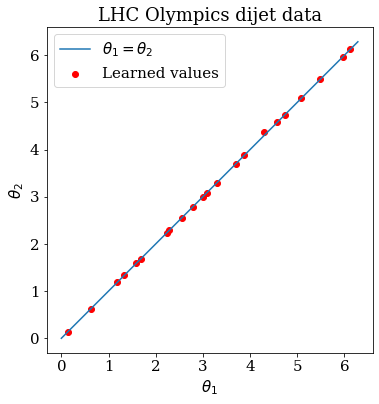

In [9]:
plt.rc('font', size=15)
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect(1)
plt.scatter(t1f % (2*np.pi), t2f % (2*np.pi), color='r', label="Learned values")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.plot(np.linspace(0,2*np.pi), np.linspace(0,2*np.pi), label = r"$\theta_1 = \theta_2$")
plt.legend()
plt.title("LHC Olympics dijet data")
plt.savefig("LHCO.pdf", bbox_inches='tight')

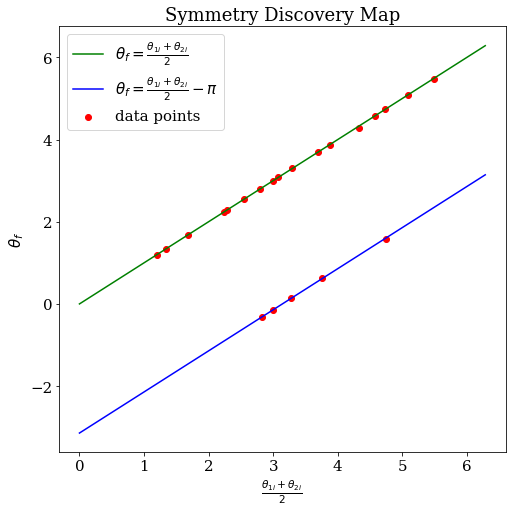

In [16]:
plt.rc('font', size=15)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(7/11)
plt.scatter((t1i + t2i)/2 , t1f, color='r', label='data points')
plt.xlabel(r"$\frac{\theta_{1i} + \theta_{2i}}{2}$")
plt.ylabel(r"$\theta_f$")
plt.plot(np.linspace(0,2*np.pi), np.linspace(0,2*np.pi), label = r"$\theta_f = \frac{\theta_{1i} + \theta_{2i}}{2}$", color='g')
plt.plot(np.linspace(0,2*np.pi), np.linspace(0,2*np.pi) - np.pi, label = r"$\theta_f = \frac{\theta_{1i} + \theta_{2i}}{2}-\pi$", color='b')
plt.title("Symmetry Discovery Map")
plt.legend()
plt.savefig("LHCO_avg.pdf", bbox_inches='tight')


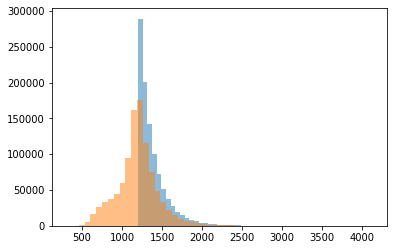

In [20]:
plt.hist(np.sqrt(px1**2 + py1**2), bins=50, alpha=0.5)
plt.hist(np.sqrt(px2**2 + py2**2), bins=50, alpha=0.5)
plt.show()